# Time Series Anomaly Detection Exercises

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?

## Acquire the Data

In [2]:
df = pd.read_csv('anonymized-curriculum-access.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
#check the shape of the data
df.shape

(900223, 6)

In [4]:
#Get the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       900223 non-null  object 
 1   1       900223 non-null  object 
 2   2       900222 non-null  object 
 3   3       900223 non-null  int64  
 4   4       847330 non-null  float64
 5   5       900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [5]:
df.describe()

,3,4
count,900223.000000,847330.000000
mean,458.825707,48.501049
std,249.296767,32.795482
min,1.000000,1.000000
25%,269.000000,28.000000
50%,475.000000,33.000000
75%,660.000000,57.000000
max,981.000000,139.000000


## Prepare the Data

In [9]:
#rename columns
df.rename(columns={0: 'date', 1: 'time', 2: 'page', 3: 'user_id', 4:'cohort_id', 5: 'ip'}, inplace=True)

In [67]:
#fill nulls in cohort id with 0
df.cohort_id = df.cohort_id.fillna('0')

In [11]:
#Create a datetime column by concatenating date and time
df['dt'] = df['date'] + ' ' + df['time']

In [13]:
#Drop date and time columns
df.drop(columns={'date', 'time'}, inplace=True)

In [17]:
#Convert dt to datetime object
df.dt = pd.to_datetime(df.dt)

In [20]:
#set dt as index
df = df.set_index('dt')
df.head()

,page,user_id,cohort_id,ip
dt,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [66]:
def prep_access_logs(df):
    '''
    This function takes in the dataframe containing access logs
    for the Codeup Curriculum and prepares it for analysis by:
    
    - Renaming the columns
    - Concatenting the date and time columns to a dt column and setting is as a datetime index
    - Filling the nulls in co_hort with 0
    
    It returns a prepared dataframe.
    '''
    #Rename the columns
    df.rename(columns={0: 'date', 1: 'time', 2: 'page', 3: 'user_id', 4:'cohort_id', 5: 'ip'}, inplace=True)
    
    #Create a datetime column by concatenating date and time
    df['dt'] = df['date'] + ' ' + df['time']
    
    #Drop date and time columns
    df.drop(columns={'date', 'time'}, inplace=True)
    
    #Convert dt to datetime object
    df.dt = pd.to_datetime(df.dt)
    
    #set dt as index
    df = df.set_index('dt')
    
    #Fill nulls in co_hort id 
    df.cohort_id = df.cohort_id.fillna('0')
    
    return df

## Explore the Data

**Can I find myself in this data?**

In [22]:
#Find myself using my ip address
df.loc[df.ip =='148.66.39.72']

,page,user_id,cohort_id,ip
dt,,,,
2020-12-08 10:53:12,/,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/intro-to-data-science,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/modern-data-scientist.jpg,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/AI-ML-DL-timeline.jpg,845,133.0,148.66.39.72
2020-12-08 10:59:35,fundamentals/pipeline-demo,845,133.0,148.66.39.72
...,...,...,...,...
2021-04-20 21:52:54,search/search_index.json,845,133.0,148.66.39.72
2021-04-20 22:41:40,classification/acquire,845,133.0,148.66.39.72
2021-04-21 09:03:04,anomaly-detection/overview,845,133.0,148.66.39.72


**Explore Easley Co Hort**

In [23]:
#Create a dataframe to explore the easley cohort access log data
easley_cohort = df[df.cohort_id == 133]

In [24]:
easley_cohort.head()

,page,user_id,cohort_id,ip
dt,,,,
2020-12-08 10:49:37,/,835,133.0,173.173.109.5
2020-12-08 10:49:39,/,836,133.0,99.43.137.186
2020-12-08 10:49:40,/,837,133.0,66.69.79.82
2020-12-08 10:49:52,/,838,133.0,99.158.249.67
2020-12-08 10:50:16,/,839,133.0,130.45.49.89


<AxesSubplot:xlabel='dt'>

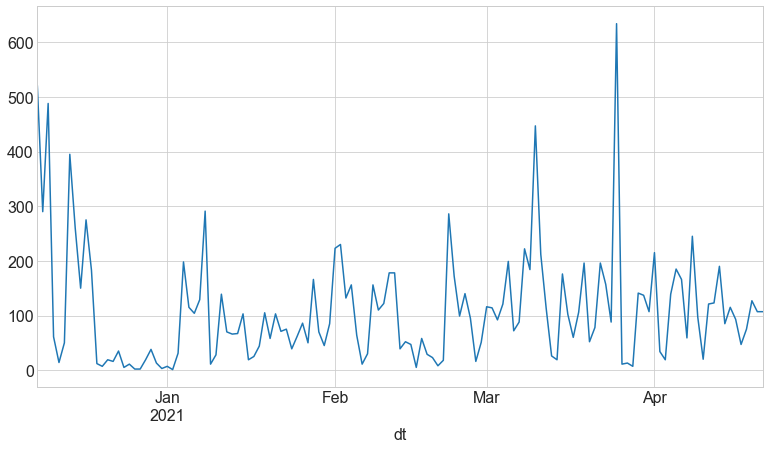

In [64]:
#Plot easley cohort access to logs over time
easley_cohort.resample('D').user_id.count().plot()

<AxesSubplot:>

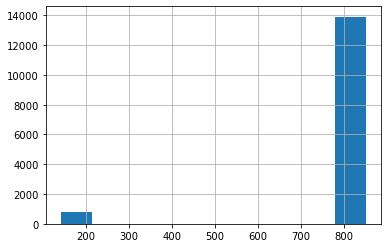

In [35]:
#Check the dist of easley user_id
easley_cohort.user_id.hist()

In [46]:
easley_cohort.user_id.describe()

count    14715.000000
mean       804.069113
std        159.412310
min        143.000000
25%        837.000000
50%        842.000000
75%        845.000000
max        851.000000
Name: user_id, dtype: float64

In [47]:
#Check how many unique user_ids there are for the easley co-hort
easley_cohort.user_id.nunique()

17

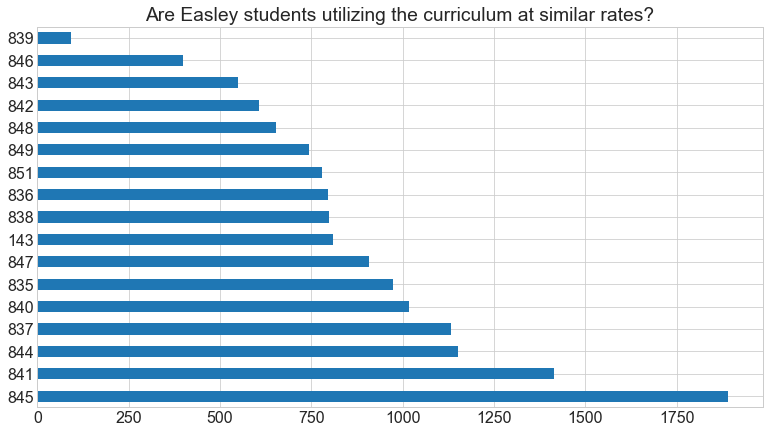

In [83]:
#What are the value counts for accessing
easley_cohort.user_id.value_counts().plot(kind='barh')
plt.title('Are Easley students utilizing the curriculum at similar rates?')
plt.show()

**Takeaways:**
- What is the outlier user id? User == 143?
- 17 easley students and 17 unique user ids


In [85]:
justin_curr_usage = easley_cohort[easley_cohort.user_id == 845]

In [86]:
justin_curr_usage.head()

,page,user_id,cohort_id,ip
dt,,,,
2020-12-08 10:53:12,/,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/intro-to-data-science,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/modern-data-scientist.jpg,845,133.0,148.66.39.72
2020-12-08 10:59:21,fundamentals/AI-ML-DL-timeline.jpg,845,133.0,148.66.39.72
2020-12-08 10:59:35,fundamentals/pipeline-demo,845,133.0,148.66.39.72


<AxesSubplot:xlabel='dt'>

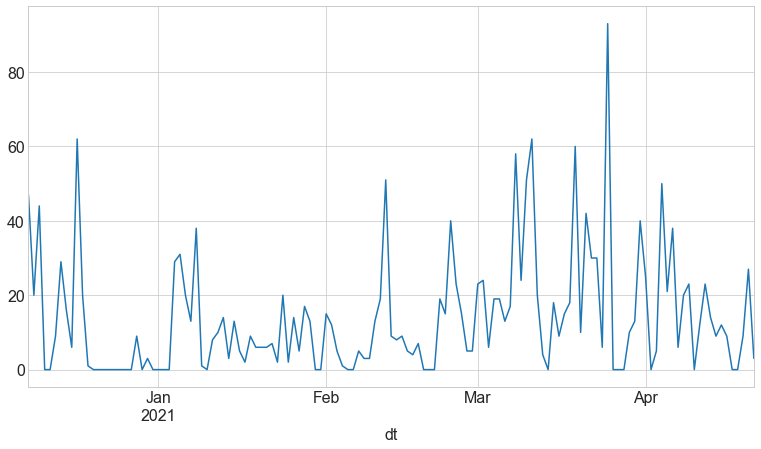

In [89]:
justin_curr_usage.resample('D').page.count().plot()

**Exploration for Access Counts Based on IP Address**

In [77]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'access_counts']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['access_counts']).count()

,ip
access_counts,
1,822
2,554
3,490
4,370
5,272
...,...
4754,1
6791,1
9515,1


In [63]:
# filter where access_counts == 1
ip_counts[ip_counts['access_counts'] == 1]

,ip,access_counts
4709,107.77.201.227,1
4710,72.177.198.47,1
4711,184.203.149.107,1
4712,174.197.6.43,1
4713,107.77.217.189,1
...,...,...
5526,96.8.177.40,1
5527,65.121.50.194,1
5528,173.239.240.49,1
5529,99.203.155.78,1


**Takeaways:**
- 822 accessed the codeup curriculum only 1 time

**Exploration with TSA**

AttributeError: 'SeriesGroupBy' object has no attribute 'scatterplot'